# Generation and analysis of Ligand-Protein IFPs for RAMD simulations (dcd trajectories)

    1. Computing interaction fingerprints (IFP) for 
        system equilibration trajectory 
        ligand dissociation trajectories
    2.  Visualizion of 
        protein residues that are involved in protein-ligand interactions, including water-bridges
        ligand dissociation   


### Author: Daria Kokh
    v.1.0
    Copyright (c) 2019
    Released under the GNU Public Licence, v2 or any higher version
    


### Input data required:
    - trajectory file 
    - pdb file (for example, generated from the first frame)
    - ligand mole2 and pdb files
    
    All examples are  provided in the Data directory:
        - Data/2YKI  - an example of the  analysis of a single PDB file 
        - Data/6EI5/ - an example of the analysis of a single trajectory
        - Data/4MQT/ORTO-CHL-lipid14/ - an example of the analysis of several trajectories obtained from RAMD simulations
    
### Packages required:
    numpy
    pandas
    matplotlib
    MDAnalysis
    RDkit
    scipy
    code is written on Python 3.x and tested on Python 3.7




#  Application example: GPCR embedded in a membrane

    GPCR - Muscarinic Receptor M2 in a membrane
    Membrane containing cholesterol 50%  + POPC + POPE and M2 muscarinic receptor (PDB ID=4MQT)

##  1. Computation of PL IFPs  for a single dcd trajectory

    Generation of PL IFP  for a membrane protein bound to a ligand (muscarinic receptor M2; PDB:4MQT)
    
    Data used:
    PDB file of a complete system equilibrated using AMBER
    MD trajectory in DCD format (generated using NAMD software)
    ligand PDB and Mol2 files 
    (Important: not all Mol2 formats can be read by RDKit, file generated by MOE software works well)
    
    Result:
    A database (df_prop_complet) will be generated; it contains PL IFP for each frame analyzed


In [1]:
from Scripts.IFP_generation import *
from Scripts.Trajectories import *
from rdkit import Chem

the total length of trajectory:  721  frames
Will be analized:  52  frames
Ligand properties:  ({'Acceptor': ['O09', 'O12'], 'PosIonizable': ['N02'], 'Hydrophobe': ['C14', 'C06', 'C07']}, <rdkit.Chem.rdchem.Mol object at 0x7f6c72e95940>)
Ligand properties:
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
IXO
Ligand properties:  {'Acceptor': ['O09', 'O12'], 'PosIonizable': ['N02'], 'Hydrophobe': ['C14', 'C06', 'C07']}
Start HB analysis 14:14:46.854666
Start WB analysis 14:14:49.788308
Start collecting IFPs:  14:15:27.173854
Start building IFP table:  14:17:08.556722
IFP database is ready  14:17:08.579946


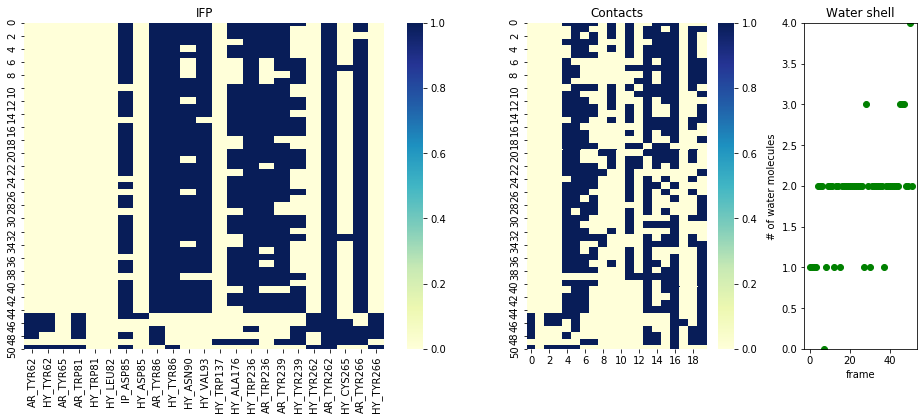

In [2]:


# 1. define input data........................................... 
ref =  "Data/4MQT/ORTO-CHL-lipid14/AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
traj = "Data/4MQT/ORTO-CHL-lipid14/RAMD/Replica1/Traj1/ORTO-CHL_108_ramd_016.dcd"
ligand_pdb = "Data/4MQT/ORTO-CHL-lipid14/IXO.pdb"
ligand_mol2 = "Data/4MQT/ORTO-CHL-lipid14/moe.mol2"
# define a part of the trajectory to be analized
start = 200
stop = -1
step = 10
#.................................................................

# 2. load trajectory.............................................
u = mda.Universe(ref,traj)
print("the total length of trajectory: ",len(u.trajectory)," frames")
# define ligand residue name
sel_ligands = " IXO "
# define a sub-sistem to be analized (we will skip membrane residues to make simulations faster)
system_reduced = u.select_atoms(" protein or (resname WAT "+sel_ligands+")")
# load trajectory in memory
u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=start,stop=stop,step=step).results,format=MemoryReader)
print("Will be analized: ",len(u_mem.trajectory)," frames")
#................................................................

# 3. get ligand chemical properties: 
#one can either use a function ligand_properties..........................
properties_list = ligand_properties(ligand_pdb,ligand_mol2)
print("Ligand properties: ",properties_list)
#or use a ligand object (that, for example, considers also F3 as a hydrophobic group)
my_ligand = Ligand("./",ligand_pdb,ligand_mol2)
print(my_ligand.ligands_names[0])
properties_list = my_ligand.property_list
print("Ligand properties: ",properties_list)
#.............................................................

#4.   IFP analysis:
# compute IFP
df_prop,df_HB,df_WB = IFP(u_mem,sel_ligands,properties_list,WB_analysis=True,RE=True,Lipids= [])
#build a table of IFPs
df_prop_complete = table_combine(df_HB,df_WB,df_prop,sel_ligands)

#5.  Plot results
Plot_IFP(df_prop_complete)

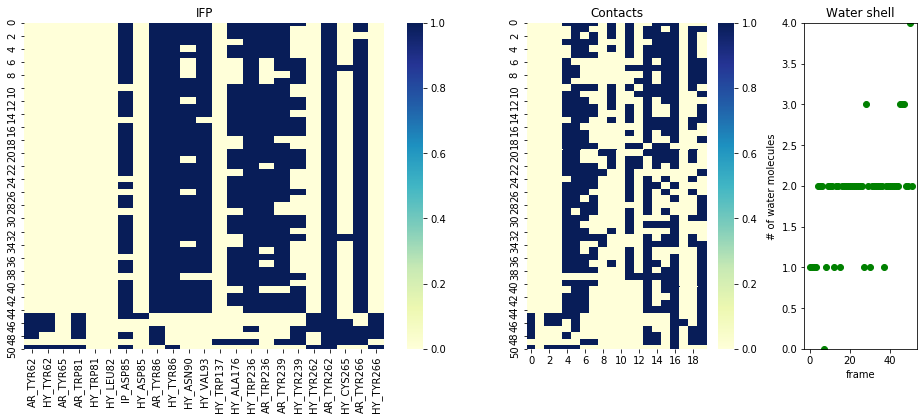

In [2]:
Plot_IFP(df_prop_complete)

##  2. Generation the IFP database using a trajectory object


### 2.1 Loading all  trajectories in one container (Trajectory object)

In [3]:
######################
#
#    tauRAMD analysis for Muscarinic receptor
#
#######################

DIR_all = "Data/4MQT/ORTO-CHL-lipid14/"
DIR_ramd = "RAMD/Replica*"
DIR_namd = "NAMD_eq/Replica*"
ref =  "AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
ligandPDB = "IXO.pdb"
ligandMol2 = "moe.mol2"

tr = trajectories(DIR_all,namd_tmpl= DIR_namd, ramd_tmpl= DIR_ramd,ligand_pdb=ligandPDB,\
                          ligand_mol2=ligandMol2,ramd_traj_tmpl = "Traj*/*dcd",pdb = ref, timestep = 1)

Ligand properties:
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
2  Equilibration trajectories found
2  RAMD traj. found in  Data/4MQT/ORTO-CHL-lipid14//RAMD/Replica1
2  RAMD traj. found in  Data/4MQT/ORTO-CHL-lipid14//RAMD/Replica2


## 2.2 Computation of PL IFPs for all equilibration trajectories

In [4]:
#auxi_selection = ["((resid 8:21) and (not type H))","((resid 48:65) and (not type H))","((resid 88:91) and (not type H))","((resid 151:157) and (not type H))"]
tr.analysis_all_namd(WB_analysis = True, Lipids = [],auxi_selection = auxi_selection,step_analysis=step, start_analysis=-300)
IFP_table = tr.namd.IFP_save(tr.PRJ_DIR+name+"-NAMD.pkl")


NameError: name 'auxi_selection' is not defined

### 2.3 Computation of PL IFPs for all dissociation trajectories

In [ ]:
# read RAMD trajectories
tr.ramd.scan_ramd()
# Compute IFP for RAMD dissociation trajectories (only the last 200 snapshots)
tr.analysis_all_ramd(WB_analysis = True, step_analysis=2, start_analysis=-200)
# save IFP
tr.ramd.IFP_save(tr.PRJ_DIR+name+"-RAMD_com.pkl")

### 2.3  PL  IFP table can be loaded from the file saved previously and plot IFP for dissociation trajectories

In [ ]:
# read and visualize RAMD IFP
Plot_IFP(pd.read_pickle(tr.PRJ_DIR+"ORTO-CHL-lipid14_RAMD_com.pkl"))